<p style = "font-size : 50px; color : #532e1c ; font-family : 'SimHei'; text-align : center; background-color : #bedcfa; border-radius: 5px 5px;"><strong>汽车贷款违约预测</strong></p>

# 案例背景

汽车贷款违约预测

通过对数据的分析，评估客户的贷款偿还能力，并确定影响借款人偿还贷款能力的每个因素的相对重要性。
目的是预测客户是否可能拖欠汽车贷款付款。
完成以下任务：
（1）原始数据为loan.xlsx，需自己切分数据为X_train, X_test,（训练集）和 y_train, y_test（测试集）；
（2）检查数据中是否存在重复观测、缺失值、异常值（如:"x1"、"x8"中部分值为 "$"，x17 中部分值为"x";；"x35"中部分值为 "&"）等，部分数值以"2345"形式存储，并对其进行相应的处理 # @ 等
（3）对字符型的离散变量做相应的重编码。
（4）多种分类器的尝试（推荐尝试lightgbm、RandomForest）

In [1]:
# necessary imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import warnings

warnings.filterwarnings('ignore')

# 加载数据

In [2]:
df = pd.read_excel('loan.xlsx')
df = df.drop(columns=['ID'])
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x30,x31,x32,x33,x34,x35,x36,x37,x38,Label
0,40500,0.0,1.0,0.0,1.0,0.0,130381.2,3825,Alone,Service,...,Yes,Yes,Business Entity Type 3,NaN,0.422830,0.429424,0.1031,NaN,2.0,0
1,13500,0.0,0.0,1.0,0.0,0.0,50249.7,3087,Alone,Service,...,No,Yes,NaN,0.466366,0.535488,0.728141299,NaN,746.0,1.0,0
2,18000,0.0,0.0,0.0,1.0,1.0,53910,2765.25,Alone,Service,...,Yes,Yes,Self-employed,0.120829,0.635048,0.073965146,NaN,671.0,1.0,0
3,11250,0.0,0.0,1.0,0.0,0.0,51206.4,2386.8,Alone,Service,...,Yes,Yes,Industry: type 13,NaN,0.074752,NaN,NaN,1029.0,NaN,1
4,20250,0.0,1.0,0.0,1.0,0.0,NaN,NaN,Alone,Commercial,...,Yes,Yes,Realtor,NaN,0.724004,0.647977,0.0165,2633.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90168,26100,1.0,0.0,0.0,0.0,0.0,59256,NaN,Alone,Govt Job,...,Yes,No,Military,0.118334,0.519962,0.524496,NaN,387.0,0.0,0
90169,13050,0.0,1.0,0.0,1.0,1.0,49752,2790.9,Alone,Govt Job,...,Yes,Yes,Kindergarten,NaN,0.653686,0.533482,0.0412,1062.0,3.0,0
90170,29250,0.0,0.0,1.0,1.0,2.0,108900,4626.9,Alone,Govt Job,...,Yes,Yes,Government,NaN,0.300915,NaN,NaN,1777.0,2.0,0
90171,18000,0.0,1.0,0.0,1.0,0.0,37692,1673.1,Alone,Commercial,...,Yes,Yes,Trade: type 3,0.746619,0.652165,0.739412,0.0423,1353.0,2.0,0


In [3]:
ll = df.columns.values.tolist()
ll

['x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x19',
 'x20',
 'x21',
 'x22',
 'x23',
 'x24',
 'x25',
 'x26',
 'x27',
 'x28',
 'x29',
 'x30',
 'x31',
 'x32',
 'x33',
 'x34',
 'x35',
 'x36',
 'x37',
 'x38',
 'Label']

In [4]:
label = pd.read_csv('Data_Dictionary.csv', encoding='gbk')
label

,变量,含义
0,ID,客户贷款申请ID
1,x1,客户收入（美元）
2,x2,客户在申请汽车贷款之前是否拥有任何汽车（0表示没有，1表示没有）
3,x3,客户是否拥有的任何自行车（0代表没有，1代表没有）。
4,x4,在申请贷款时，是否有其他有效的贷款（0表示没有，1表示没有）。
5,x5,客户拥有的任何房产（0代表没有，1代表没有）。
6,x6,客户有多少个孩子
7,x7,贷款的信贷金额（美元）
8,x8,贷款年金（Loan annuity，美元）
9,x9,当客户申请贷款时，谁陪同客户一起去的？


# 数据质量的探索性分析

## 数值型数据的基本统计值
首先，需要知道每个变量的基本统计值，如均值、中位数、四分位数、最大值、最小值等

In [5]:
df.describe()

,x2,x3,x4,x5,x6,x21,x22,x23,x24,x26,x27,x28,x29,x33,x34,x36,x37,x38,Label
count,87535.000000,87518.000000,87503.000000,87433.000000,87496.000000,31006.000000,90173.000000,90173.000000,90173.000000,88334.000000,88346.000000,88384.000000,87447.000000,39274.000000,85959.000000,44342.000000,87403.000000,76390.000000,90173.000000
mean,0.344251,0.333429,0.497766,0.692953,0.419128,12.157647,0.999989,0.200282,0.280627,2.155920,2.029373,3.153783,12.065434,0.501807,0.517844,0.117378,961.330629,1.888218,0.080068
std,0.475126,0.471441,0.499998,0.461271,0.730232,12.078480,0.003330,0.400213,0.449308,0.911982,0.504581,1.761313,3.283991,0.211027,0.705314,0.108251,828.895190,1.859321,0.271400
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.014568,0.000016,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.334038,0.389625,0.057700,271.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,9.000000,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,12.000000,0.505311,0.565086,0.088700,753.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000,0.000000,1.000000,3.000000,2.000000,5.000000,14.000000,0.674729,0.663639,0.148500,1569.000000,3.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,19.000000,69.000000,1.000000,1.000000,1.000000,16.000000,3.000000,6.000000,23.000000,0.945741,100.000000,1.000000,4185.000000,22.000000,1.000000


## 查看数据信息

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90173 entries, 0 to 90172
Data columns (total 39 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      87511 non-null  object 
 1   x2      87535 non-null  float64
 2   x3      87518 non-null  float64
 3   x4      87503 non-null  float64
 4   x5      87433 non-null  float64
 5   x6      87496 non-null  float64
 6   x7      87494 non-null  object 
 7   x8      86637 non-null  object 
 8   x9      88898 non-null  object 
 9   x10     87431 non-null  object 
 10  x11     87500 non-null  object 
 11  x12     87607 non-null  object 
 12  x13     88416 non-null  object 
 13  x14     87430 non-null  object 
 14  x15     87421 non-null  object 
 15  x16     86601 non-null  object 
 16  x17     87476 non-null  object 
 17  x18     87468 non-null  object 
 18  x19     87464 non-null  object 
 19  x20     85772 non-null  object 
 20  x21     31006 non-null  float64
 21  x22     90173 non-null  int64  
 22

## 数据质量检测

In [7]:
# 是否有缺失值
df.isnull().sum()

x1        2662
x2        2638
x3        2655
x4        2670
x5        2740
x6        2677
x7        2679
x8        3536
x9        1275
x10       2742
x11       2673
x12       2566
x13       1757
x14       2743
x15       2752
x16       3572
x17       2697
x18       2705
x19       2709
x20       4401
x21      59167
x22          0
x23          0
x24          0
x25      30622
x26       1839
x27       1827
x28       1789
x29       2726
x30          0
x31          0
x32       2646
x33      50899
x34       4214
x35      19951
x36      45831
x37       2770
x38      13783
Label        0
dtype: int64

# 数据预处理

## 异常值处理

    x1 (客户收入（美元）)、x7 (贷款的信贷金额（美元）)、x8(贷款年金（Loan annuity，美元）)   包含： $

    x17(客户在提交申请时的年龄)、x18(在申请贷款前，客户受雇天数)、x19(在申请贷款的前几天，客户更改了他/她的注册信息) 、(在申请贷款前几天，客户更换了申请贷款的ID信息)  包含：  x

    x35(其他来源评分3（标准化数据）)  包含：&

    x16(客户所居住地区的相对人口。较高的值意味着客户生活在人口较多的地区)  包含 ：#
    x16(客户所居住地区的相对人口。较高的值意味着客户生活在人口较多的地区)   包含 ：@

In [8]:
# 将不明符号替换为指定值（例如替换为0）
df[['x1', 'x7', 'x8']] = df[['x1', 'x7', 'x8']].replace(['$'], 0)
df[['x17', 'x18', 'x19']] = df[['x17', 'x18', 'x19']].replace(['x'], 0)
df['x35'] = df['x35'].replace(['&'], 0)
df['x16'] = df['x16'].replace(['#', '@'], 0)

In [9]:
df1 =df.copy()
result_1 = df1[['x1', 'x7', 'x8']].isin(['$']).value_counts()
print(result_1)
result_2 = df1[['x17', 'x18', 'x19']].isin(['x']).value_counts()
print(result_2)
result_3 = df1[['x35']].isin(['&']).value_counts()
print(result_3)
result_4 = df1[['x16']].isin(['#', '@']).value_counts()
print(result_4)

x1     x7     x8   
False  False  False    90173
dtype: int64
x17    x18    x19  
False  False  False    90173
dtype: int64
x35  
False    90173
dtype: int64
x16  
False    90173
dtype: int64


## 缺失值处理

In [10]:
dd = df.copy()
dd = dd.fillna(method='pad')
dd = dd.fillna(dd.mean())

In [11]:
dd.isnull().sum()

x1       0
x2       0
x3       0
x4       0
x5       0
x6       0
x7       0
x8       0
x9       0
x10      0
x11      0
x12      0
x13      0
x14      0
x15      0
x16      0
x17      0
x18      0
x19      0
x20      0
x21      0
x22      0
x23      0
x24      0
x25      0
x26      0
x27      0
x28      0
x29      0
x30      0
x31      0
x32      0
x33      0
x34      0
x35      0
x36      0
x37      0
x38      0
Label    0
dtype: int64

## 散变量的重编码

使用sklearn.preprocessing 中的 LabelEncoder  或  OrdinalEncoder 均可

In [12]:
from sklearn.preprocessing import OrdinalEncoder

# 使用 OrdinalEncoder 进行编码
ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform(df.astype(str).values.tolist())
print(encoded_data)
print(ordinal_encoder.categories_)

[[6.700e+02 0.000e+00 1.000e+00 ... 3.538e+03 1.100e+01 0.000e+00]
 [1.570e+02 0.000e+00 0.000e+00 ... 3.257e+03 1.000e+00 0.000e+00]
 [3.300e+02 0.000e+00 0.000e+00 ... 3.174e+03 1.000e+00 0.000e+00]
 ...
 [5.540e+02 0.000e+00 0.000e+00 ... 8.650e+02 1.100e+01 0.000e+00]
 [3.300e+02 0.000e+00 1.000e+00 ... 3.950e+02 1.100e+01 0.000e+00]
 [9.620e+02 2.000e+00 0.000e+00 ... 3.118e+03 1.600e+01 0.000e+00]]
[array(['0', '10035', '10047.6', ..., '9945', '9949.05', 'nan'],
      dtype=object), array(['0.0', '1.0', 'nan'], dtype=object), array(['0.0', '1.0', 'nan'], dtype=object), array(['0.0', '1.0', 'nan'], dtype=object), array(['0.0', '1.0', 'nan'], dtype=object), array(['0.0', '1.0', '10.0', '12.0', '14.0', '19.0', '2.0', '3.0', '4.0',
       '5.0', '6.0', '7.0', '8.0', '9.0', 'nan'], dtype=object), array(['0', '100041.75', '100113.3', ..., '99912.15', '99988.65', 'nan'],
      dtype=object), array(['#VALUE!', '0', '1000.35', ..., '999.45', '999.9', 'nan'],
      dtype=object), array(['#

In [13]:
dd = pd.DataFrame(encoded_data, columns=ll)
dd.head(10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x30,x31,x32,x33,x34,x35,x36,x37,x38,Label
0,670.0,0.0,1.0,0.0,1.0,0.0,720.0,5719.0,1.0,5.0,...,1.0,1.0,5.0,34119.0,17393.0,455.0,536.0,3538.0,11.0,0.0
1,157.0,0.0,0.0,1.0,0.0,0.0,2462.0,4346.0,1.0,5.0,...,0.0,1.0,58.0,15150.0,26504.0,631.0,1755.0,3257.0,1.0,0.0
2,330.0,0.0,0.0,0.0,1.0,1.0,2577.0,3687.0,1.0,5.0,...,1.0,1.0,42.0,867.0,37927.0,144.0,1755.0,3174.0,1.0,0.0
3,56.0,0.0,0.0,1.0,0.0,0.0,2488.0,2910.0,1.0,5.0,...,1.0,1.0,18.0,34119.0,1967.0,761.0,1755.0,35.0,21.0,1.0
4,393.0,0.0,1.0,0.0,1.0,0.0,3846.0,10103.0,1.0,1.0,...,1.0,1.0,36.0,34119.0,49612.0,579.0,61.0,1817.0,1.0,0.0
5,296.0,0.0,0.0,2.0,1.0,0.0,1824.0,903.0,1.0,4.0,...,1.0,1.0,57.0,27586.0,51046.0,225.0,1264.0,907.0,11.0,0.0
6,706.0,0.0,1.0,1.0,1.0,0.0,3359.0,2890.0,1.0,4.0,...,1.0,1.0,57.0,34119.0,34442.0,562.0,1755.0,0.0,0.0,0.0
7,577.0,0.0,1.0,0.0,1.0,0.0,1348.0,1652.0,1.0,5.0,...,1.0,1.0,24.0,31374.0,12796.0,648.0,1755.0,3534.0,11.0,0.0
8,962.0,0.0,1.0,0.0,0.0,0.0,1703.0,3206.0,6.0,4.0,...,1.0,1.0,57.0,34119.0,48290.0,678.0,1132.0,456.0,11.0,0.0
9,530.0,0.0,0.0,1.0,0.0,6.0,2031.0,3925.0,1.0,5.0,...,1.0,1.0,10.0,29281.0,55446.0,471.0,1755.0,2832.0,1.0,0.0


## 数据类型转换

In [14]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90173 entries, 0 to 90172
Data columns (total 39 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      90173 non-null  float64
 1   x2      90173 non-null  float64
 2   x3      90173 non-null  float64
 3   x4      90173 non-null  float64
 4   x5      90173 non-null  float64
 5   x6      90173 non-null  float64
 6   x7      90173 non-null  float64
 7   x8      90173 non-null  float64
 8   x9      90173 non-null  float64
 9   x10     90173 non-null  float64
 10  x11     90173 non-null  float64
 11  x12     90173 non-null  float64
 12  x13     90173 non-null  float64
 13  x14     90173 non-null  float64
 14  x15     90173 non-null  float64
 15  x16     90173 non-null  float64
 16  x17     90173 non-null  float64
 17  x18     90173 non-null  float64
 18  x19     90173 non-null  float64
 19  x20     90173 non-null  float64
 20  x21     90173 non-null  float64
 21  x22     90173 non-null  float64
 22

## 数据归一化/标准化

In [15]:
dd.columns.values

array(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38',
       'Label'], dtype=object)

In [16]:
from sklearn.preprocessing import MinMaxScaler

X = dd.drop(columns=['Label'])
y = dd['Label']
# 创建MinMaxScaler对象
scaler = MinMaxScaler()

# 对数据进行归一化
normalized_data = scaler.fit_transform(X)

print(normalized_data)
new_dd = pd.DataFrame(normalized_data, columns=ll[:38])
new_dd.head(10)

[[0.66009852 0.         0.5        ... 0.30541311 1.         0.52380952]
 [0.1546798  0.         0.         ... 1.         0.9205766  0.04761905]
 [0.32512315 0.         0.         ... 1.         0.89711702 0.04761905]
 ...
 [0.54581281 0.         0.         ... 1.         0.24448841 0.52380952]
 [0.32512315 0.         0.5        ... 0.09458689 0.111645   0.52380952]
 [0.94778325 1.         0.         ... 0.32535613 0.88128886 0.76190476]]


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38
0,0.660099,0.0,0.5,0.0,0.5,0.000000,0.187207,0.566069,0.142857,0.625,...,0.166667,1.0,1.0,0.086207,1.000000,0.312784,0.597898,0.305413,1.000000,0.523810
1,0.154680,0.0,0.0,0.5,0.0,0.000000,0.640146,0.430169,0.142857,0.625,...,0.375000,0.0,1.0,1.000000,0.444034,0.476631,0.829172,1.000000,0.920577,0.047619
2,0.325123,0.0,0.0,0.0,0.5,0.071429,0.670047,0.364941,0.142857,0.625,...,0.375000,1.0,1.0,0.724138,0.025411,0.682054,0.189225,1.000000,0.897117,0.047619
3,0.055172,0.0,0.0,0.5,0.0,0.000000,0.646906,0.288033,0.142857,0.625,...,0.750000,1.0,1.0,0.310345,1.000000,0.035373,1.000000,1.000000,0.009893,1.000000
4,0.387192,0.0,0.5,0.0,0.5,0.000000,1.000000,1.000000,0.142857,0.125,...,0.375000,1.0,1.0,0.620690,1.000000,0.892190,0.760841,0.034758,0.513567,0.047619
5,0.291626,0.0,0.0,1.0,0.5,0.000000,0.474259,0.089379,0.142857,0.500,...,0.333333,1.0,1.0,0.982759,0.808523,0.917978,0.295664,0.720228,0.256360,0.523810
6,0.695567,0.0,0.5,0.5,0.5,0.000000,0.873375,0.286054,0.142857,0.500,...,0.333333,1.0,1.0,0.982759,1.000000,0.619382,0.738502,1.000000,0.000000,0.000000
7,0.568473,0.0,0.5,0.0,0.5,0.000000,0.350494,0.163516,0.142857,0.625,...,0.958333,1.0,1.0,0.413793,0.919546,0.230115,0.851511,1.000000,0.998869,0.523810
8,0.947783,0.0,0.5,0.0,0.0,0.000000,0.442798,0.317331,0.857143,0.500,...,0.166667,1.0,1.0,0.982759,1.000000,0.868416,0.890933,0.645014,0.128886,0.523810
9,0.522167,0.0,0.0,0.5,0.0,0.428571,0.528081,0.388498,0.142857,0.625,...,0.250000,1.0,1.0,0.172414,0.858202,0.997105,0.618922,1.000000,0.800452,0.047619


# 数据可视化

## 数据分布情况

In [17]:
_dict = y.value_counts().to_dict()
_dict

{0.0: 82953, 1.0: 7220}

Text(0.5, 1.0, 'result')

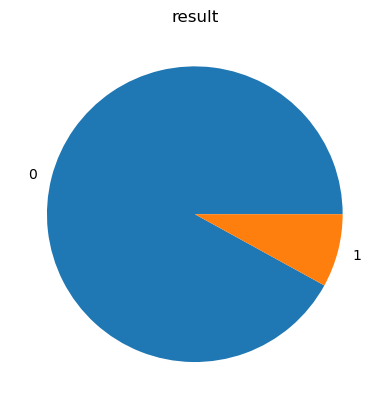

In [18]:
# 创建饼图
plt.pie(list(_dict.values()), labels=['0', '1'])

# 设置图表标题
plt.title('result')

## 数据相关情况

In [19]:
new_dd = pd.concat([new_dd, y], axis=1)
new_dd

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x30,x31,x32,x33,x34,x35,x36,x37,x38,Label
0,0.660099,0.0,0.5,0.0,0.5,0.000000,0.187207,0.566069,0.142857,0.625,...,1.0,1.0,0.086207,1.000000,0.312784,0.597898,0.305413,1.000000,0.523810,0.0
1,0.154680,0.0,0.0,0.5,0.0,0.000000,0.640146,0.430169,0.142857,0.625,...,0.0,1.0,1.000000,0.444034,0.476631,0.829172,1.000000,0.920577,0.047619,0.0
2,0.325123,0.0,0.0,0.0,0.5,0.071429,0.670047,0.364941,0.142857,0.625,...,1.0,1.0,0.724138,0.025411,0.682054,0.189225,1.000000,0.897117,0.047619,0.0
3,0.055172,0.0,0.0,0.5,0.0,0.000000,0.646906,0.288033,0.142857,0.625,...,1.0,1.0,0.310345,1.000000,0.035373,1.000000,1.000000,0.009893,1.000000,1.0
4,0.387192,0.0,0.5,0.0,0.5,0.000000,1.000000,1.000000,0.142857,0.125,...,1.0,1.0,0.620690,1.000000,0.892190,0.760841,0.034758,0.513567,0.047619,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90168,0.506404,0.5,0.0,0.0,0.0,0.000000,0.714249,1.000000,0.142857,0.250,...,1.0,0.0,0.534483,0.024297,0.450555,0.667543,1.000000,0.802431,0.000000,0.0
90169,0.137931,0.0,0.5,0.0,0.5,0.071429,0.635465,0.370088,0.142857,0.250,...,1.0,1.0,0.482759,1.000000,0.725754,0.674113,0.092308,0.020350,0.666667,0.0
90170,0.545813,0.0,0.0,0.5,0.5,0.428571,0.062663,0.693259,0.142857,0.250,...,1.0,1.0,0.189655,1.000000,0.187656,1.000000,1.000000,0.244488,0.523810,0.0
90171,0.325123,0.0,0.5,0.0,0.5,0.000000,0.538742,0.141146,0.142857,0.125,...,1.0,1.0,0.810345,0.849351,0.722265,0.839685,0.094587,0.111645,0.523810,0.0


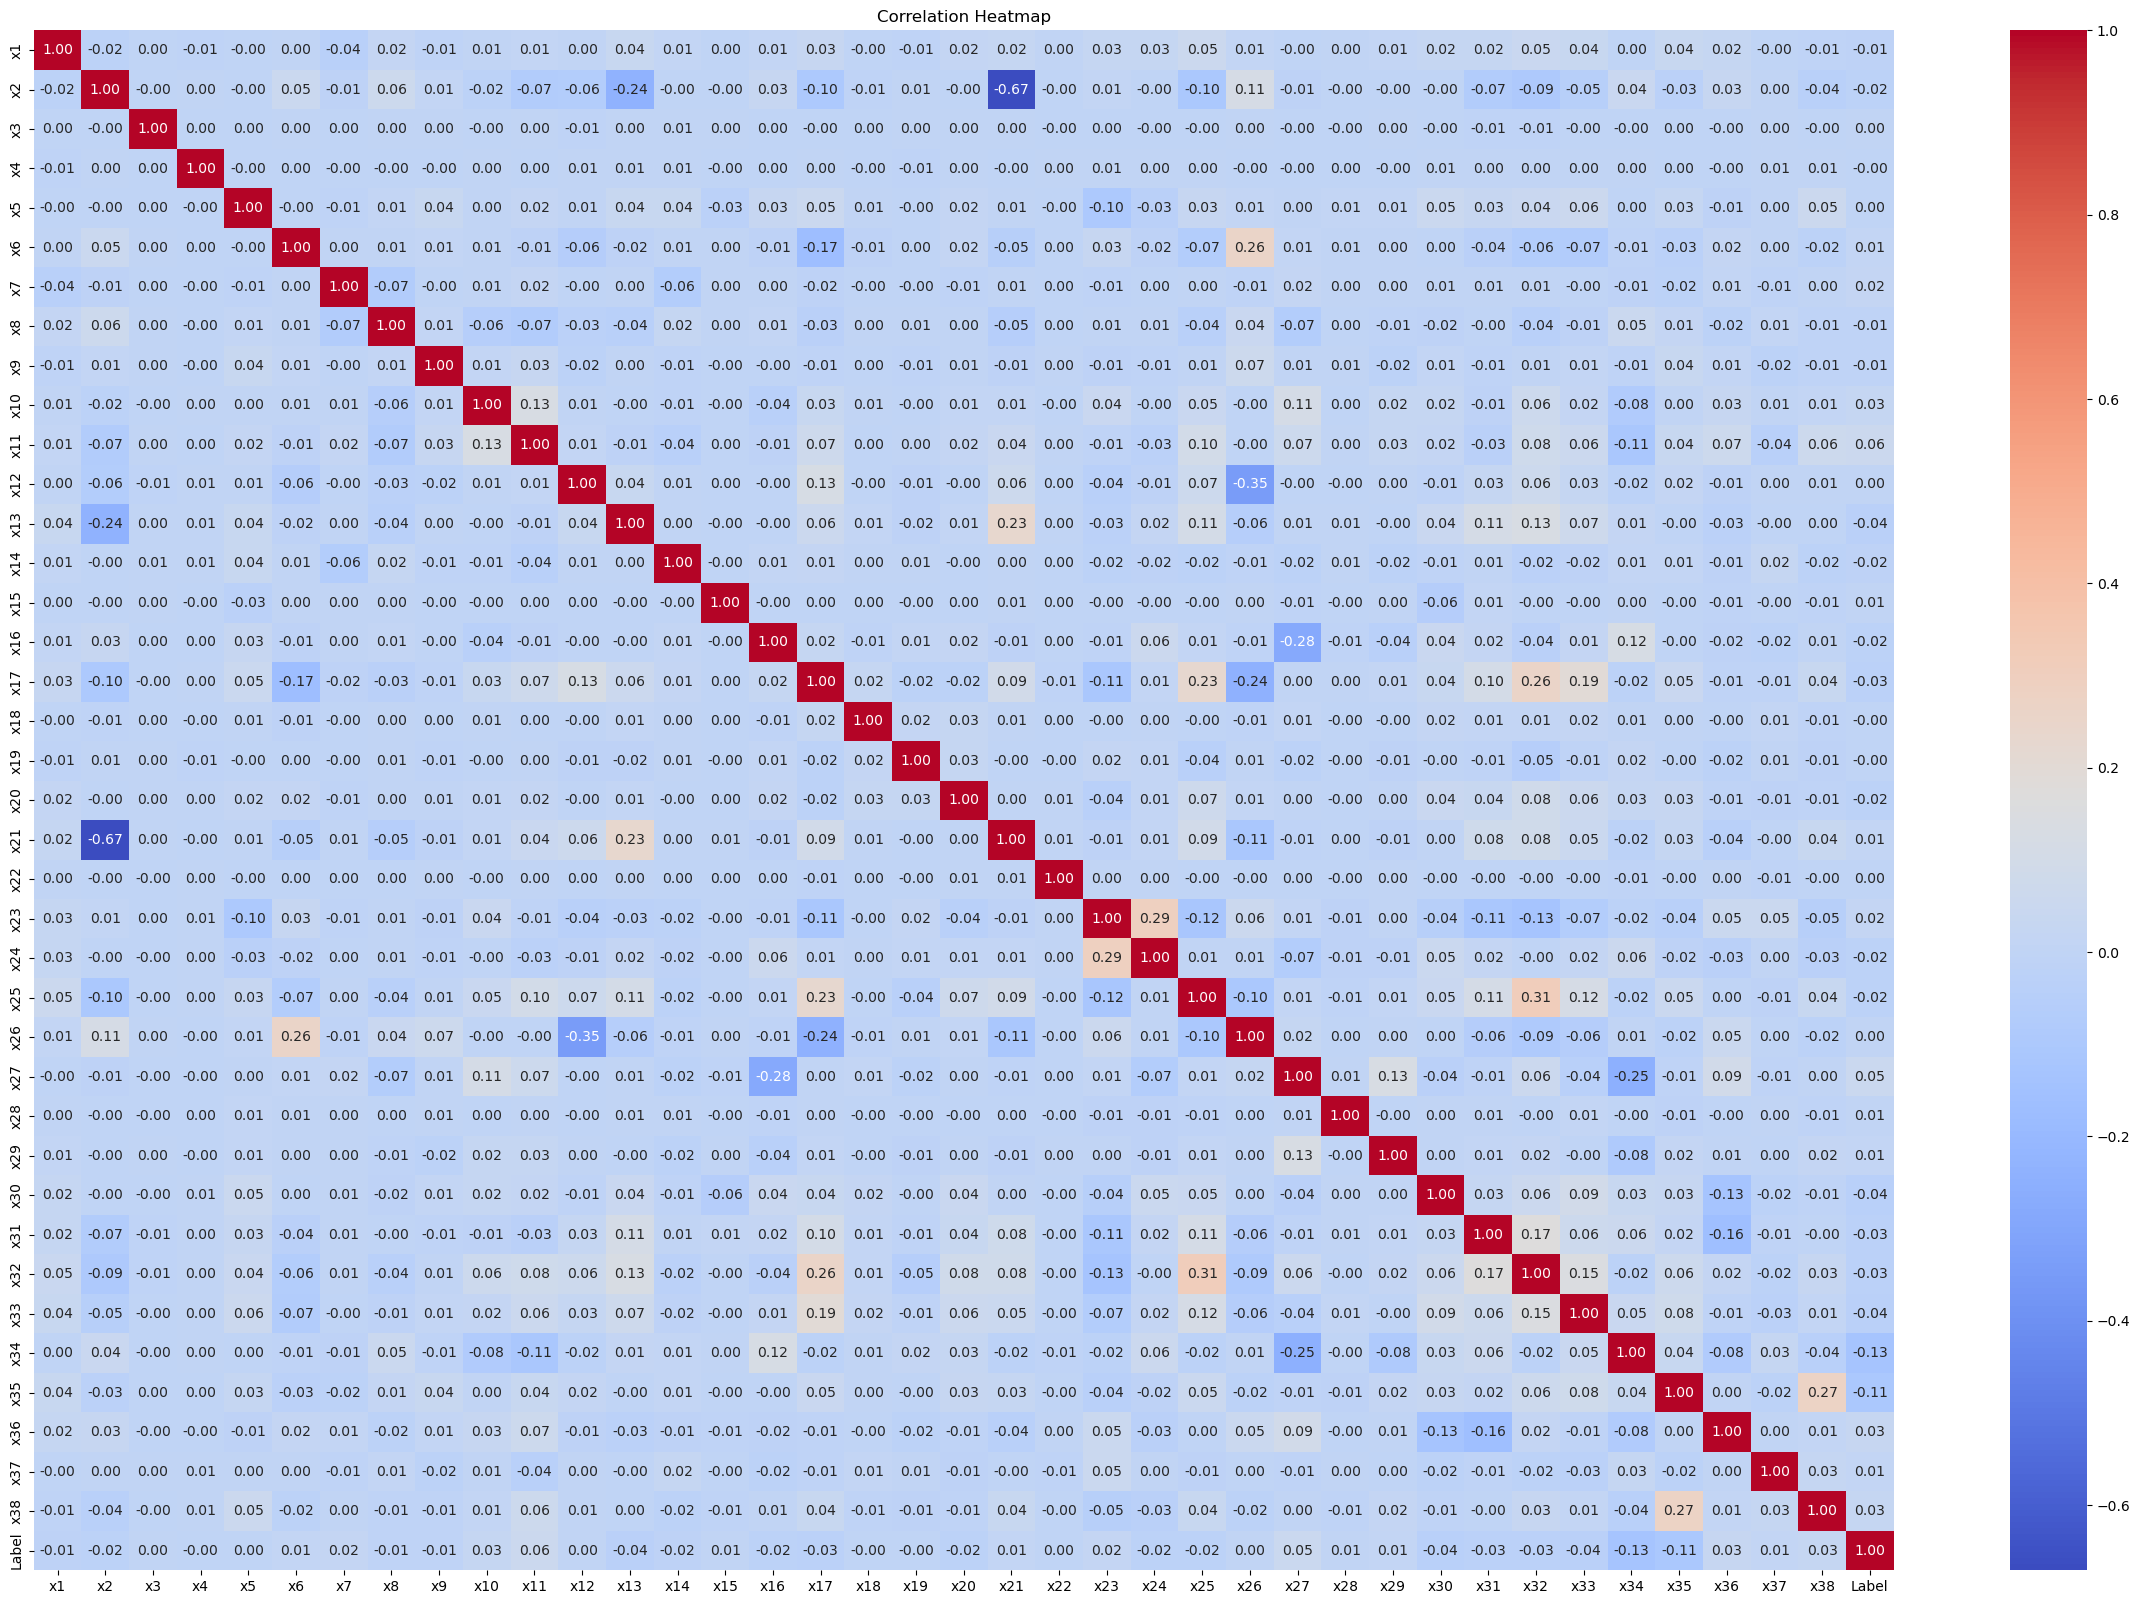

In [20]:
import seaborn as sns

# 计算相关性
correlation_matrix = dd.corr()

# 设置图形大小
plt.figure(figsize=(30, 20))

# 绘制热力图
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# 设置图表标题
plt.title('Correlation Heatmap')

# 显示图表
plt.show()

# 特征工程

## 检测和删除无关、弱相关、或冗余的属性

In [21]:
data = dd.copy()
correlation_matrix = data.corr()
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.01:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)
highly_correlated_features.discard('Label')
data.drop(columns=highly_correlated_features, inplace=True)

In [22]:
data.head(10)

,x1,x3,x4,x5,x22,Label
0,670.0,1.0,0.0,1.0,1.0,0.0
1,157.0,0.0,1.0,0.0,1.0,0.0
2,330.0,0.0,0.0,1.0,1.0,0.0
3,56.0,0.0,1.0,0.0,1.0,1.0
4,393.0,1.0,0.0,1.0,1.0,0.0
5,296.0,0.0,2.0,1.0,1.0,0.0
6,706.0,1.0,1.0,1.0,1.0,0.0
7,577.0,1.0,0.0,1.0,1.0,0.0
8,962.0,1.0,0.0,0.0,1.0,0.0
9,530.0,0.0,1.0,0.0,1.0,0.0


In [23]:
f1 = data.columns.values.tolist()
f1.remove('Label')
f1

['x1', 'x3', 'x4', 'x5', 'x22']

## 机器学习算法获得变量重要性选择部分属性

In [24]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X, y)
feature_importances = pd.Series(tree.feature_importances_, index=X.columns)
selected_features = feature_importances[feature_importances > 0.05].index.tolist()
f2 = selected_features
f2

['x8', 'x17', 'x18', 'x19', 'x20', 'x34', 'x35', 'x37']

## 生成新的属性

In [25]:
set1 = set(f1)
result = f1 + [x for x in f2 if x not in set1]
result.sort()
result

['x1',
 'x17',
 'x18',
 'x19',
 'x20',
 'x22',
 'x3',
 'x34',
 'x35',
 'x37',
 'x4',
 'x5',
 'x8']

In [26]:
data = pd.concat([new_dd[result], y], axis=1)
data

,x1,x17,x18,x19,x20,x22,x3,x34,x35,x37,x4,x5,x8,Label
0,0.660099,0.580055,0.067092,0.743954,0.142979,1.0,0.5,0.312784,0.597898,1.000000,0.0,0.5,0.566069,0.0
1,0.154680,0.117721,0.209501,0.042723,0.609021,1.0,0.0,0.476631,0.829172,0.920577,0.5,0.0,0.430169,0.0
2,0.325123,0.086871,0.124013,0.407739,0.515064,1.0,0.0,0.682054,0.189225,0.897117,0.0,0.5,0.364941,0.0
3,0.055172,0.915760,0.122822,0.429503,0.035745,1.0,0.0,0.035373,1.000000,0.009893,0.5,0.0,0.288033,1.0
4,0.387192,0.602236,0.744616,0.391030,0.486128,1.0,0.5,0.892190,0.760841,0.513567,0.0,0.5,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90168,0.506404,0.932381,0.582621,0.359519,0.057021,1.0,0.0,0.450555,0.667543,0.802431,0.0,0.0,1.000000,0.0
90169,0.137931,0.234485,0.437507,0.486589,0.789787,1.0,0.5,0.725754,0.674113,0.020350,0.0,0.5,0.370088,0.0
90170,0.545813,0.082985,0.018396,0.322292,0.501277,1.0,0.0,0.187656,1.000000,0.244488,0.5,0.5,0.693259,0.0
90171,0.325123,0.469030,0.241424,0.287410,0.081362,1.0,0.5,0.722265,0.839685,0.111645,0.0,0.5,0.141146,0.0


# 建模

## 指定分类变量和特征变量

In [27]:
X = data.drop(columns=['Label'])
y = data['Label']
X, y

(             x1       x17       x18       x19       x20  x22   x3       x34  \
 0      0.660099  0.580055  0.067092  0.743954  0.142979  1.0  0.5  0.312784   
 1      0.154680  0.117721  0.209501  0.042723  0.609021  1.0  0.0  0.476631   
 2      0.325123  0.086871  0.124013  0.407739  0.515064  1.0  0.0  0.682054   
 3      0.055172  0.915760  0.122822  0.429503  0.035745  1.0  0.0  0.035373   
 4      0.387192  0.602236  0.744616  0.391030  0.486128  1.0  0.5  0.892190   
 ...         ...       ...       ...       ...       ...  ...  ...       ...   
 90168  0.506404  0.932381  0.582621  0.359519  0.057021  1.0  0.0  0.450555   
 90169  0.137931  0.234485  0.437507  0.486589  0.789787  1.0  0.5  0.725754   
 90170  0.545813  0.082985  0.018396  0.322292  0.501277  1.0  0.0  0.187656   
 90171  0.325123  0.469030  0.241424  0.287410  0.081362  1.0  0.5  0.722265   
 90172  0.947783  0.061401  0.992858  0.656016  0.353702  1.0  0.0  0.090438   
 
             x35       x37   x4   x5  

## 数据集划分训练集测试集（7：3 或 8：2）

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [68]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## KNN

In [78]:
knn = KNeighborsClassifier(n_neighbors=5)  # 创建 KNN 分类器，指定邻居数
knn.fit(X_train, y_train)  # 在训练集上进行模型训练

KNeighborsClassifier()

### 训练集评估

In [79]:
y_train_pred = knn.predict(X_train)  

In [80]:
train_accuracy = accuracy_score(y_train, y_train_pred)  
print("Accuracy(train):", train_accuracy)

Accuracy(train): 0.9235911978580821


### 测试集评估

In [81]:
y_test_pred = knn.predict(X_test)  

In [82]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy(test):", test_accuracy)

Accuracy(test): 0.9160136034304303


## LGBM

In [83]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [112]:
# 定义参数分布
param_dist = {
    'learning_rate': sp_uniform(loc=0.001, scale=0.1),
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 10),
    'colsample_bytree': sp_uniform(loc=0.8, scale=0.2),
    'subsample': sp_uniform(loc=0.8, scale=0.2)
}

lgbm = LGBMClassifier()

random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=300, scoring='accuracy', cv=3)
random_search.fit(X_train, y_train)

print("最佳参数组合：", random_search.best_params_)
print("最佳准确度：", random_search.best_score_)

最佳参数组合： {'colsample_bytree': 0.9026725953385046, 'learning_rate': 0.07768992265440267, 'max_depth': 8, 'n_estimators': 363, 'subsample': 0.8590188760465375}
最佳准确度： 0.9202484185170735


In [113]:
lgbm = LGBMClassifier(**random_search.best_params_)
lgbm.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.9026725953385046,
               learning_rate=0.07768992265440267, max_depth=8, n_estimators=363,
               subsample=0.8590188760465375)

### 训练集评估

In [114]:
y_train_pred = lgbm.predict(X_train)  

In [115]:
train_accuracy = accuracy_score(y_train, y_train_pred)  
print("Accuracy(train):", train_accuracy)

Accuracy(train): 0.9288509370890828


### 测试集评估

In [116]:
y_test_pred = lgbm.predict(X_test)  

In [117]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy(test):", test_accuracy)

Accuracy(test): 0.9205234363448174


## 模型 C

In [ ]:
# 定义参数网格
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0]
}

lgbm = LGBMClassifier()

grid_search = GridSearchCV(lgbm, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# 输出最佳参数组合和对应的F1分数
print("最佳参数组合:", grid_search.best_params_)
print("最佳准确度:", grid_search.best_score_)

### 训练集评估

### 测试集评估

## 模型比较

# 预测

## 读入待预测数据

In [91]:
loan_prediction = pd.read_excel('loan_prediction.xlsx')
# 建模需删除id，但最终输出结果需要id，故此处需把id另存一个变量里。
loan_prediction_id = loan_prediction['ID']
loan_prediction.head()

,ID,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38
0,12182322,11250,0.0,1.0,0.0,0.0,0.0,75519,3855.6,Relative,...,9.0,Yes,Yes,Business Entity Type 3,NaN,0.550253,0.657784,0.0567,2319.0,NaN
1,12148993,11250,0.0,0.0,1.0,1.0,0.0,40965.3,1922.85,Alone,...,10.0,Yes,No,Business Entity Type 3,NaN,0.499811,NaN,NaN,805.0,NaN
2,12188699,NaN,0.0,1.0,1.0,1.0,0.0,26955,2485.35,Relative,...,13.0,Yes,Yes,Business Entity Type 2,NaN,0.632048,0.417100,0.1278,1558.0,4.0
3,12126887,22500,0.0,1.0,1.0,1.0,0.0,63000,3150,Alone,...,18.0,Yes,No,Government,0.657677,NaN,0.771362,0.3959,682.0,1.0
4,12133856,17100,0.0,1.0,1.0,1.0,0.0,108221.4,3177,Relative,...,9.0,Yes,Yes,Business Entity Type 3,NaN,0.341890,NaN,NaN,692.0,NaN


In [92]:
xx = loan_prediction[result]

In [95]:
_encoded_data = ordinal_encoder.fit_transform(xx.astype(str).values.tolist())
xx = pd.DataFrame(_encoded_data, columns=xx.columns.values.tolist())
xx.head(10)

,x1,x17,x18,x19,x20,x22,x3,x34,x35,x37,x4,x5,x8
0,40.0,4103.0,5602.0,5684.0,4423.0,0.0,1.0,11857.0,538.0,1463.0,0.0,0.0,4569.0
1,40.0,8395.0,385.0,1278.0,1753.0,0.0,0.0,9688.0,704.0,3011.0,1.0,1.0,1587.0
2,583.0,9461.0,1858.0,8340.0,3831.0,0.0,1.0,16510.0,401.0,621.0,1.0,1.0,2558.0
3,243.0,6872.0,332.0,1107.0,437.0,0.0,1.0,25036.0,616.0,2874.0,1.0,1.0,3650.0
4,167.0,9774.0,273.0,8786.0,5548.0,0.0,1.0,4957.0,704.0,2885.0,1.0,1.0,3688.0
5,72.0,5667.0,240.0,7478.0,4026.0,0.0,1.0,17537.0,454.0,3090.0,0.0,1.0,1291.0
6,96.0,2452.0,6774.0,6230.0,4292.0,0.0,0.0,4975.0,704.0,856.0,1.0,0.0,2697.0
7,583.0,9310.0,3229.0,382.0,2366.0,0.0,1.0,25036.0,613.0,918.0,0.0,1.0,1984.0
8,243.0,721.0,86.0,2856.0,5263.0,0.0,1.0,12399.0,498.0,2650.0,1.0,1.0,6194.0
9,525.0,8609.0,238.0,3927.0,2212.0,0.0,1.0,3767.0,341.0,28.0,0.0,0.0,6577.0


## 预测

In [118]:
# 预测结果
label_prediction = lgbm.predict(xx)

In [119]:
result = pd.DataFrame(columns=['ID','Label'])
result['ID'] = loan_prediction_id
result['Label']= pd.Series(label_prediction )
result

,ID,Label
0,12182322,0.0
1,12148993,0.0
2,12188699,0.0
3,12126887,0.0
4,12133856,0.0
...,...,...
31678,12198122,0.0
31679,12210703,0.0
31680,12190478,0.0
31681,12140728,0.0


In [120]:
result.to_excel('result.xlsx',index=0)

# 评分

In [121]:
data_predicted = pd.read_excel('result.xlsx')  
utils.Score(data_predicted)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     29058
           1       0.20      0.01      0.01      2625

    accuracy                           0.92     31683
   macro avg       0.56      0.50      0.48     31683
weighted avg       0.86      0.92      0.88     31683

你的成绩为：87.77
